# Kann mithilfe einer NLP-unterstützten Methodik festgestellt werden ob ein Amazon Review Positiv, Neutral oder Negativ ist, bzw. kann das angegebene Voting errechnet werden?

- Michael Hermann-Hubler
- Michael Kranl

The used data was created by J. Ni, J. Li, and J. McAuley for „Justifying Recommendations using Distantly-Labeled Reviews and Fine-Grained Aspects“, in Proceedings of the 2019 Conference on mpirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), Hong Kong, China, 2019, S. 188–197. doi: 10.18653/v1/D19-1018. 

## Imports

In [ ]:
import sys
!{sys.executable} -m pip install gzinfo
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install wordcloud
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install sklearn

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [56]:
# Intel Optimizer for Sklearn
# from sklearnex import patch_sklearn
# patch_sklearn()

# General
import pandas as pd
import numpy as np
from itertools import islice
from sklearn.model_selection import train_test_split

# Download
import urllib.request
import glob
import gzip
import gzinfo
import os
import shutil

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Preprocessing
from collections import Counter
from keras_preprocessing.text import text_to_word_sequence
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re

# Feature Representation
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Prediction
import tensorflow as tf
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Huggingface
from datasets import Dataset, features
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import create_optimizer

# RNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import keras.models as kmodels
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_squared_error, accuracy_score

# Set to true on Production
final_Execution = True

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Dataset

### Download Sub Dataset

In [2]:
subdatasets = [
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Industrial_and_Scientific_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz'
              ]

def download(x: str):
    urllib.request.urlretrieve(x, '.data/dummy.gz')

    filename = gzinfo.read_gz_info('.data/dummy.gz').fname
    with gzip.open('.data/dummy.gz', 'rb') as f_in:
        with open('.data/' + filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    os.remove('.data/dummy.gz')

# only run once as this can take a very long time
if len(os.listdir('.data') ) == 0:
    [download(x) for x in subdatasets]


## Load data

In [3]:
all_files = glob.glob('.data/*')
li = []

for filename in all_files:
    temp_df = pd.read_json(filename, lines=True)
    li.append(temp_df)

df = pd.concat(li, axis=0, ignore_index=True)

## Data Exploration I

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 29, 2016",AIE8N9U317ZBM,0449819906,{'Format:': ' Kindle Edition'},"Zelmira, Ph.D.",Contains some interesting stitches.,Four Stars,1459209600,NaN,NaN
1,5,True,"08 12, 2015",A3ECOW0TWLH9V6,0449819906,{'Format:': ' Paperback'},Dangerous when Cooking,I'm a fairly experienced knitter of the one-co...,My current favorite go-to guide for inspiration,1439337600,18,NaN
2,4,True,"04 5, 2015",A278N8QX9TY2OS,0449819906,{'Format:': ' Paperback'},Just us,Great book but the index is terrible. Had to w...,"lots of great examples, good instructions, col...",1428192000,3,NaN
3,5,True,"10 11, 2014",A123W8HIK76XCN,0449819906,{'Format:': ' Kindle Edition'},Amazon Customer,I purchased the Kindle edition which is incred...,Another little gem by Melissa Leapman,1412985600,NaN,NaN
4,5,True,"05 8, 2014",A2A6MZ2QB4AE0L,0449819906,{'Format:': ' Paperback'},Sustainability,Very well laid out and very easy to read.\n\nT...,Very comprehensive,1399507200,NaN,NaN


In [5]:
df.describe()

,overall,unixReviewTime
count,837226.000000,8.372260e+05
mean,4.524777,1.446987e+09
std,0.953090,4.959673e+07
min,1.000000,1.051402e+09
25%,4.000000,1.418429e+09
50%,5.000000,1.452470e+09
75%,5.000000,1.483402e+09
max,5.000000,1.538525e+09


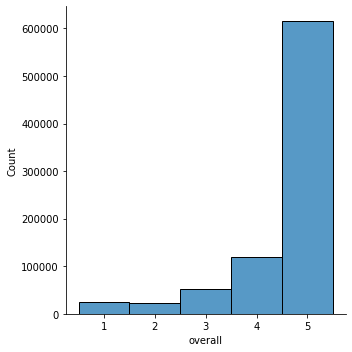

In [6]:
sns.displot(df.overall, discrete=True)

In [7]:
df.groupby('overall').count().reviewText

overall
1     25394
2     23489
3     52973
4    119795
5    615214
Name: reviewText, dtype: int64

The high average overall score means, that we have to split the data differently as we have no normal distibution.

In [8]:
print('Length whole Dataset:', len(df.reviewText))
print('Length Dataset without NA:', len(df.reviewText.dropna()))

Length whole Dataset: 837226
Length Dataset without NA: 836865


There exists missing Data

## Data Cleaning

### Remove unnessesary columns

In [9]:
df = df[['overall', 'reviewText']]

### Remove missing data

In [10]:
df = df.dropna()

### Reduce data to a representative subset
To reduce the data we take random 20.000 samples from each class, without replacement

In [11]:
sampling_size = 20000

li = [
    df[df.overall == 1].sample(sampling_size),
    df[df.overall == 2].sample(sampling_size),
    df[df.overall == 3].sample(sampling_size),
    df[df.overall == 4].sample(sampling_size),
    df[df.overall == 5].sample(sampling_size)
]

df_cleaned = pd.concat(li, axis=0, ignore_index=True)

In [12]:
df_cleaned.describe()

,overall
count,5000.000000
mean,3.000000
std,1.414355
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [13]:
df_cleaned.head()

,overall,reviewText
0,1,Too Short! I had to rob another strap with a ...
1,1,Very cheap and flimsy. Not able to hold anythi...
2,1,The Alvin Professional translucent self-healin...
3,1,Best described as flimsy- got what I paid for ...
4,1,Worked fine when driven by my keyboard: Keyboa...


## Preprocessing

### Lowercasing

In [14]:
df_lowercase = df_cleaned.copy()
df_lowercase.reviewText = df_lowercase.reviewText.str.lower()
df_lowercase.head()

,overall,reviewText
0,1,too short! i had to rob another strap with a ...
1,1,very cheap and flimsy. not able to hold anythi...
2,1,the alvin professional translucent self-healin...
3,1,best described as flimsy- got what i paid for ...
4,1,worked fine when driven by my keyboard: keyboa...


### Remove Special Chars

In [15]:
regex = '[^ A-Za-z]+'

df_spec_cars_removed = df_lowercase.copy()
df_spec_cars_removed.reviewText = df_spec_cars_removed.apply(lambda row: re.sub(regex, '', row.reviewText), axis=1)
df_spec_cars_removed.head()

,overall,reviewText
0,1,too short i had to rob another strap with a l...
1,1,very cheap and flimsy not able to hold anythin...
2,1,the alvin professional translucent selfhealing...
3,1,best described as flimsy got what i paid for here
4,1,worked fine when driven by my keyboard keyboar...


### Tokenization

In [16]:
df_token = df_spec_cars_removed.copy()
df_token.reviewText = df_token.apply(lambda row: text_to_word_sequence(row.reviewText), axis=1)
df_token.head()

,overall,reviewText
0,1,"[too, short, i, had, to, rob, another, strap, ..."
1,1,"[very, cheap, and, flimsy, not, able, to, hold..."
2,1,"[the, alvin, professional, translucent, selfhe..."
3,1,"[best, described, as, flimsy, got, what, i, pa..."
4,1,"[worked, fine, when, driven, by, my, keyboard,..."


## Remove seldom used words

In [17]:
df_token_cleaned = df_token.copy()

counts = Counter()
for _, row in df_token_cleaned.iterrows():
    counts.update(row.reviewText)

print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 5:
        del counts[word]
print("num_words after:",len(counts.keys()))


for index, row in df_token_cleaned.iterrows():
    df_token_cleaned.at[index, 'reviewText'] = [x for x in row.reviewText if x in counts.keys()]   

df_token_cleaned.head()

num_words before: 15269
num_words after: 3651


,overall,reviewText
0,1,"[too, short, i, had, to, another, strap, with,..."
1,1,"[very, cheap, and, flimsy, not, able, to, hold..."
2,1,"[the, professional, translucent, cutting, mat,..."
3,1,"[best, described, as, flimsy, got, what, i, pa..."
4,1,"[worked, fine, when, by, my, keyboard, keyboar..."


### Lemmatization 

In [18]:
lemmatizer = WordNetLemmatizer()

df_lemm = df_token_cleaned.copy()
df_lemm.reviewText = df_lemm.apply(lambda row: [lemmatizer.lemmatize(x) for x in row.reviewText], axis=1)
df_lemm.head()

,overall,reviewText
0,1,"[too, short, i, had, to, another, strap, with,..."
1,1,"[very, cheap, and, flimsy, not, able, to, hold..."
2,1,"[the, professional, translucent, cutting, mat,..."
3,1,"[best, described, a, flimsy, got, what, i, pai..."
4,1,"[worked, fine, when, by, my, keyboard, keyboar..."


### Stemming

Stemming ist used additionally to lemtization, because time forms were not normalized

In [19]:
stemmer = PorterStemmer()

df_stemm = df_lemm.copy()
df_stemm.reviewText = df_stemm.apply(lambda row: [stemmer.stem(x) for x in row.reviewText], axis=1)
df_stemm.head()

,overall,reviewText
0,1,"[too, short, i, had, to, anoth, strap, with, a..."
1,1,"[veri, cheap, and, flimsi, not, abl, to, hold,..."
2,1,"[the, profession, transluc, cut, mat, come, wi..."
3,1,"[best, describ, a, flimsi, got, what, i, paid,..."
4,1,"[work, fine, when, by, my, keyboard, keyboard,..."


### Stopword removal

In [20]:
stopwords_en = stopwords.words('english')

df_removed_stopwords = df_stemm.copy()
df_removed_stopwords.reviewText = df_removed_stopwords.apply(lambda row: [x for x in row.reviewText if x not in stopwords_en and x not in ['\n', '\r']], axis=1)
df_removed_stopwords.head()

,overall,reviewText
0,1,"[short, anoth, strap, longer, strip, larg, man..."
1,1,"[veri, cheap, flimsi, abl, hold, anyth, onto, ..."
2,1,"[profession, transluc, cut, mat, come, label, ..."
3,1,"[best, describ, flimsi, got, paid]"
4,1,"[work, fine, keyboard, keyboard, midi, respond..."


### Define final

In [21]:
df_final = df_token_cleaned[df_token_cleaned.reviewText.map(lambda d: len(d)) > 0]

df_final

,overall,reviewText
0,1,"[too, short, i, had, to, another, strap, with,..."
1,1,"[very, cheap, and, flimsy, not, able, to, hold..."
2,1,"[the, professional, translucent, cutting, mat,..."
3,1,"[best, described, as, flimsy, got, what, i, pa..."
4,1,"[worked, fine, when, by, my, keyboard, keyboar..."
...,...,...
4994,5,"[the, description, didnt, say, whether, for, o..."
4995,5,"[this, is, a, pretty, deep, color, not, a, bri..."
4996,5,"[i, love, this, product, it, meets, all, of, m..."
4997,5,"[i, have, used, this, on, almost, every, proje..."


## Data Exploration II

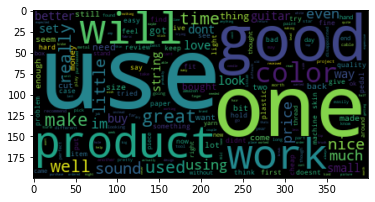

In [22]:
word_list = df_final.reviewText.tolist()
word_list = [i for j in word_list for i in j]

word_list_text = ' '.join(word_list)

wordcloud = WordCloud().generate(word_list_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

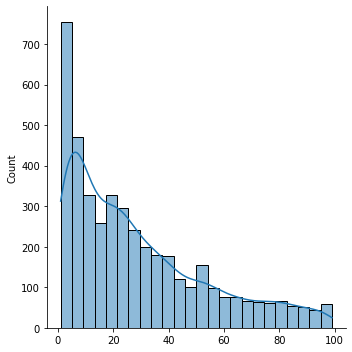

In [23]:
word_counts = [df_final.reviewText.apply(len)][0]
word_counts = [x for x in word_counts if x < 100]

sns.displot(word_counts, kde=True)

In [24]:
[x for x in df_final.reviewText if len(x) < 5][:10]


[['mine', 'caught', 'fire'],
 ['bad', 'product', 'it', 'broke'],
 ['too', 'tiny'],
 ['of', 'the', 'strings', 'high'],
 ['its', 'in', 'the', 'trash'],
 ['of', 's'],
 ['good', 'leds'],
 ['very', 'uncomfortable', 'waste', 'of'],
 ['blow'],
 ['not', 'waste', 'of', 'money']]

These results with just one word seem plausible, thus they will be included

## Feature Representation

### n-Gram

In [25]:
n = 3
ngram = ngrams(df_final.reviewText, n)

df_ngram = df_final.copy()
df_ngram['ngram'] = df_ngram.reviewText

df_ngram.loc[df_ngram.reviewText.apply(len) >= n, 'ngram'] = [list(ngrams(x, n)) for x in df_ngram.reviewText if len(x) >= n]

df_ngram

C:\Users\micha\anaconda3\envs\AIAPP_NLP\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,overall,reviewText,ngram
0,1,"[too, short, i, had, to, another, strap, with,...","[(too, short, i), (short, i, had), (i, had, to..."
1,1,"[very, cheap, and, flimsy, not, able, to, hold...","[(very, cheap, and), (cheap, and, flimsy), (an..."
2,1,"[the, professional, translucent, cutting, mat,...","[(the, professional, translucent), (profession..."
3,1,"[best, described, as, flimsy, got, what, i, pa...","[(best, described, as), (described, as, flimsy..."
4,1,"[worked, fine, when, by, my, keyboard, keyboar...","[(worked, fine, when), (fine, when, by), (when..."
...,...,...,...
4994,5,"[the, description, didnt, say, whether, for, o...","[(the, description, didnt), (description, didn..."
4995,5,"[this, is, a, pretty, deep, color, not, a, bri...","[(this, is, a), (is, a, pretty), (a, pretty, d..."
4996,5,"[i, love, this, product, it, meets, all, of, m...","[(i, love, this), (love, this, product), (this..."
4997,5,"[i, have, used, this, on, almost, every, proje...","[(i, have, used), (have, used, this), (used, t..."


### TF-IDF

In [26]:
def take(n, iterable):
    return list(islice(iterable, n))

vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=(lambda x:x),
    preprocessor=(lambda x:x),
    token_pattern=None
)

vectorizer.fit(df_final.reviewText)
take(10, vectorizer.vocabulary_.items())

[('too', 3276),
 ('short', 2784),
 ('i', 1465),
 ('had', 1330),
 ('to', 3266),
 ('another', 127),
 ('strap', 3033),
 ('with', 3567),
 ('a', 0),
 ('longer', 1755)]

### Word2Vec and Sentenec Vectors

In [27]:
w2v_model = Word2Vec(df_final.reviewText, vector_size=100, window=5, min_count=2)

def getSentenceAvgFromW2V(df):
    words = set(w2v_model.wv.index_to_key )
    vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in df.reviewText])

    vect_avg = []
    for v in vect:
        if v.size:
            vect_avg.append(v.mean(axis=0))
        else:
            vect_avg.append(np.zeros(100, dtype=float))

    return vect_avg

## Clustering

### Preparing Sample
A sample is needed because of memory Reasons

In [28]:
if final_Execution:
    df_sample = df_final
else:
    df_sample = df_final.sample(n=(int)(sampling_size/20))
X = vectorizer.transform(df_sample.reviewText)
X.toarray()

array([[0.03909446, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08203129, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10824203, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## KMeans + PCA

In [29]:
# do Ellbow Plot only for final Execution, as this takes a very long time

if final_Execution:
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        distortions.append(kmeanModel.inertia_)    

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()



Upper Limit of 20, because the Optimum (~35) cannot be displayed


Cluster 0
trying,up,line,apart,tip,fell,threads,change,great,works

Cluster 1
traditional,smoother,good,paper,and,quilt,set,size,quality,nice

Cluster 2
and,is,for,to,this,not,it,a,i,the

Cluster 3
well,works,switch,sound,rack,switches,holes,guitar,part,excellent

Cluster 4
marking,colors,just,package,light,beads,what,pick,selection,great


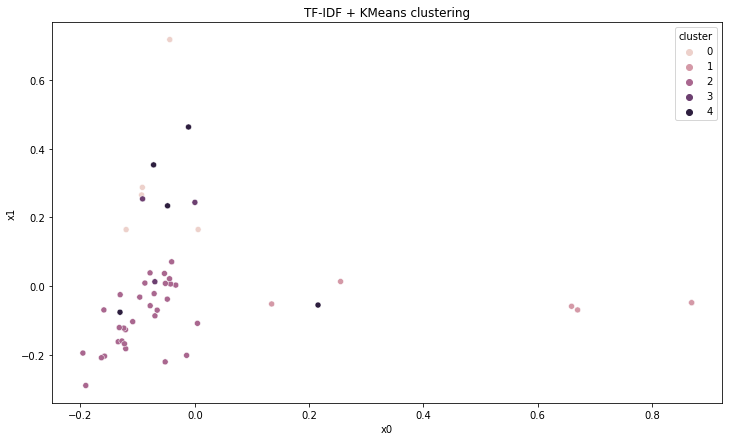

In [30]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())

df_sample['cluster'] = clusters
df_sample['x0'] = pca_vecs[:, 0]
df_sample['x1'] = pca_vecs[:, 1]

get_top_keywords(10)

plt.figure(figsize=(12, 7))
plt.title("TF-IDF + KMeans clustering")
sns.scatterplot(data=df_sample, x='x0', y='x1', hue='cluster')
plt.show()

### TSNE

C:\Users\micha\anaconda3\envs\AIAPP_NLP\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\micha\anaconda3\envs\AIAPP_NLP\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.112198
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.663399
[t-SNE] KL divergence after 1000 iterations: 1.108851


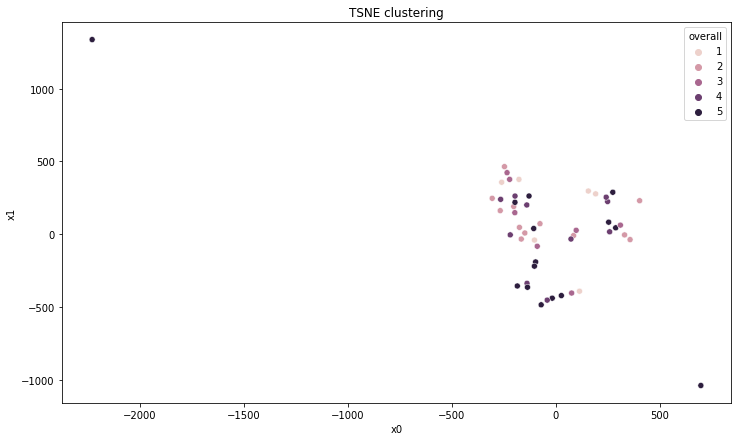

In [31]:
model = TSNE(n_components=2, verbose=1, perplexity=2)
z = model.fit_transform(X)

#df_sample['cluster'] = clusters
df_sample['x0'] = z[:,0]
df_sample['x1'] = z[:,1]

plt.figure(figsize=(12, 7))
plt.title("TSNE clustering")
sns.scatterplot(data=df_sample, x='x0', y='x1', hue='overall')
plt.show()

## UMAP

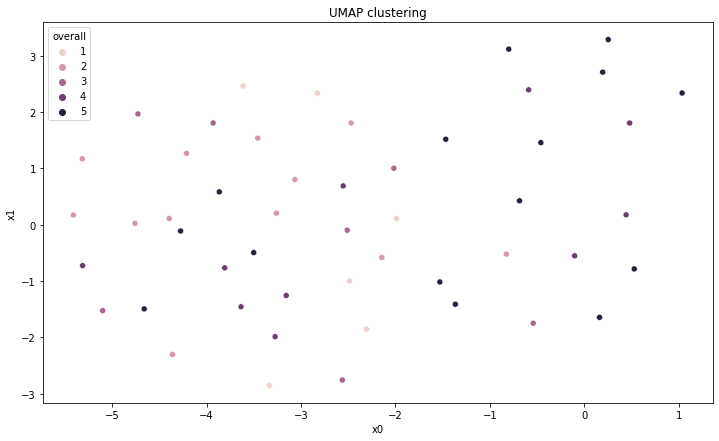

In [32]:
reducer = UMAP(n_neighbors=20, min_dist=0.8)
v_embed = reducer.fit_transform(X)

df_sample['x0'] = v_embed[:,0]
df_sample['x1'] = v_embed[:,1]

plt.figure(figsize=(12, 7))
plt.title("UMAP clustering")
sns.scatterplot(x="x0", y="x1", data=df_sample, hue='overall')
plt.show()

# Preditction using Regression

We will try two different approaches to predict the classes. Firstly we will try Regression, to find out if an approach weighting their similarity is suitable (A review rating 2 is more similar to a review rating 3 than a review rating 5).

To do this we will use 4 approaches:
- SVR
- Random Forrest Regressor
- LSTM 
- Transformer

## SVR

In [33]:
x = getSentenceAvgFromW2V(df_sample)
y = df_sample.overall.values

x_train_total, x_test, y_train_total, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_total, y_train_total, test_size=0.2)

svr_model = SVR()
svr_model.fit(x_train, y_train)

y_pred = svr_model.predict(x_val)
print('MRSE:', mean_squared_error(y_val, y_pred))

MRSE: 2.4046416734340914


C:\Users\micha\AppData\Local\Temp\ipykernel_30532\1217449317.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in df.reviewText])


## Random Forrest

In [34]:
x = getSentenceAvgFromW2V(df_sample)
y = df_sample.overall.values

x_train_total, x_test, y_train_total, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_total, y_train_total, test_size=0.2)

rfr_model = RandomForestRegressor()
rfr_model.fit(x_train, y_train)

y_pred = rfr_model.predict(x_val)
print('MRSE:', mean_squared_error(y_val, y_pred))

MRSE: 5.334611805555555


C:\Users\micha\AppData\Local\Temp\ipykernel_30532\1217449317.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in df.reviewText])


## Pytorch

### Pytorch Preprocessing

In [65]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

def encode_sentence(tokenized, vocab2index, N=70):
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

df_sample['encoded'] = df_sample['reviewText'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))

x = df_sample.encoded
y = df_sample.overall

x_train_total, x_test, y_train_total, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_total, y_train_total, test_size=0.2)

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


C:\Users\micha\AppData\Local\Temp\ipykernel_30532\1532207141.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_sample['encoded'] = df_sample['reviewText'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))


### Pytorch Dataset

In [66]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.x = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        #print(self.x)
        return torch.from_numpy(self.x[idx][0].astype(np.int32)).to(device), self.y[idx], self.x[idx][1]
        #return torch.from_numpy(self.x[idx][0].astype(np.int32)), self.y[idx], self.x[idx][1]

train_ds = ReviewDataset(x_train, y_train)
val_ds = ReviewDataset(x_val, y_val)
test_ds = ReviewDataset(x_test, y_test)

### Pytorch Training Loop

In [67]:
def train_model_regr(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.float().to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.mse_loss(y_pred, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss = validation_metrics_regr(model, val_dl)
        if i % 5 == 1:
            print("train mse %.3f val rmse %.3f" % (sum_loss/total, val_loss))

def validation_metrics_regr (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.float()
        y_hat = model(x, l).cpu()
        loss = np.sqrt(F.mse_loss(y_hat, y.unsqueeze(-1)).item())
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total

batch_size = 5000
vocab_size = len(words)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)

### Pytorch Model

In [68]:
class my_LSTM(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])
        
lstm_model =  my_LSTM(vocab_size, 1000, 500)
lstm_model.to(device)

my_LSTM(
  (embeddings): Embedding(3653, 1000, padding_idx=0)
  (lstm): LSTM(1000, 500, batch_first=True)
  (linear): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [69]:
train_model_regr(lstm_model, epochs=40, lr=0.01)

train mse 8.159 val rmse 5.151
train mse 5.651 val rmse 2.302
train mse 3.429 val rmse 1.649
train mse 2.342 val rmse 2.220
train mse 1.765 val rmse 1.277
train mse 1.901 val rmse 1.500
train mse 1.498 val rmse 1.760
train mse 1.284 val rmse 2.424


In [71]:
torch.save(lstm_model, './RNN_Reg_Model')

## Huggingface / Transformer

In [41]:
df_transformer = df_cleaned.reset_index(drop=True)

df_transformer['label'] = df_transformer.overall
df_transformer['text'] = df_transformer.reviewText

df_transformer = df_transformer.drop(['overall', 'reviewText'], axis=1)

train, test = train_test_split(df_transformer)

ds_train = Dataset.from_pandas(train, preserve_index=False)
ds_test = Dataset.from_pandas(test, preserve_index=False)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

def preprocess_function_amazon(examples):
    return tokenizer(examples["review_body"], truncation=True)

ds_train.features['label'] = features.ClassLabel(1)
ds_test.features['label'] = features.ClassLabel(1)

In [42]:
tokenized_train = ds_train.map(preprocess_function, batched=True)
tokenized_test = ds_test.map(preprocess_function, batched=True)

100%|██████████| 2/2 [00:00<00:00, 33.33ba/s]


In [43]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [44]:
tf_train_set = tokenized_train.to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=4,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_test.to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=4,
    collate_fn=data_collator,
)

In [45]:
batch_size = 4
num_epochs = 1
batches_per_epoch = len(tokenized_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [73]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1, output_attentions=True)

model.compile(optimizer=optimizer)
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_59', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/2


 12/937 [..............................] - ETA: 8:05 - loss: 0.0087 - attentions_3_loss: 0.0087

KeyboardInterrupt: 

In [47]:
print('Loss: ', 0.0115)

Loss:  0.0115


In [74]:
model.save_pretrained(save_directory='./Transformer_Model')

## Prediction using Classification

In the second step we will predict the classes without weighting the result on other classes (A review result 2 is as dissimilar to a review result 1 as a review result 5)

In this step we will use 3 approaches:
- SVM
- Random Forrest
- RNN

## SVM

In [48]:
x = getSentenceAvgFromW2V(df_sample)
y = df_sample.overall.values

x_train_total, x_test, y_train_total, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_total, y_train_total, test_size=0.2)

svm_model = SVC()
svm_model.fit(x_train, y_train)

y_pred = svm_model.predict(x_val)

print('Accuracy:', accuracy_score(y_val, y_pred))

Accuracy: 0.25


C:\Users\micha\AppData\Local\Temp\ipykernel_30532\1217449317.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in df.reviewText])


## Random Forrest

In [49]:
x = getSentenceAvgFromW2V(df_sample)
y = df_sample.overall.values

x_train_total, x_test, y_train_total, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_total, y_train_total, test_size=0.2)

rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train)

y_pred = rfc_model.predict(x_val)

print('Accuracy:', accuracy_score(y_val, y_pred))

Accuracy: 0.25


C:\Users\micha\AppData\Local\Temp\ipykernel_30532\1217449317.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in df.reviewText])


# RNN

Show content of dataset.

In [50]:
df_tf_input = df_final.copy()
df_tf_input.head()

,overall,reviewText
0,1,"[too, short, i, had, to, another, strap, with,..."
1,1,"[very, cheap, and, flimsy, not, able, to, hold..."
2,1,"[the, professional, translucent, cutting, mat,..."
3,1,"[best, described, as, flimsy, got, what, i, pa..."
4,1,"[worked, fine, when, by, my, keyboard, keyboar..."


Tokenize the review texts.

In [51]:
# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each review.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS 
                      #,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
                      #,ower=True
                      )
tokenizer.fit_on_texts(df_tf_input['reviewText'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3651 unique tokens.


Convert text to number sequences and create the feature tensor X.

In [52]:
X = tokenizer.texts_to_sequences(df_tf_input['reviewText'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
print(X)

Shape of data tensor: (4983, 200)
[[   0    0    0 ...  341   13   63]
 [   0    0    0 ...   28   23  981]
 [   0    0    0 ...   34  236 1265]
 ...
 [   0    0    0 ...    7    1  439]
 [   0    0    0 ...   10 1605 3592]
 [   0    0    0 ...   88   45  183]]


Create the target tensor Y.

In [53]:
Y = pd.get_dummies(df_tf_input['overall']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (4983, 5)


Create train/test datasets. Test dataset contains 10% of the data. Set random_state to ensure reproductability.

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4484, 200) (4484, 5)
(499, 200) (499, 5)


Create new model of no saved model was found.

In [57]:

if os.path.exists("./RNN_model") == False:
    print("Created new model as no saved model was found...")
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    new_model = True
else:
    print("Loading saved model...")
    model = kmodels.load_model("./RNN_model")
    new_model = False
print(model.summary())

Created new model as no saved model was found...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


If new model was created: Start training. Otherwise skip training phase.

In [58]:
if(new_model):
    print("New model created - training starts...")
    epochs = 5
    batch_size = 64

    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
else:
    print("Skip training and use existing model")


New model created - training starts...
Epoch 1/5
64/64 [==============================] - 11s 155ms/step - loss: 1.5742 - accuracy: 0.2659 - val_loss: 1.5635 - val_accuracy: 0.2650
Epoch 2/5
64/64 [==============================] - 9s 142ms/step - loss: 1.4075 - accuracy: 0.3779 - val_loss: 1.4036 - val_accuracy: 0.3541
Epoch 3/5
64/64 [==============================] - 9s 146ms/step - loss: 1.1747 - accuracy: 0.4922 - val_loss: 1.3381 - val_accuracy: 0.3831
Epoch 4/5
64/64 [==============================] - 10s 152ms/step - loss: 1.0370 - accuracy: 0.5705 - val_loss: 1.3599 - val_accuracy: 0.3853
Epoch 5/5
64/64 [==============================] - 9s 148ms/step - loss: 0.9021 - accuracy: 0.6307 - val_loss: 1.4344 - val_accuracy: 0.3541


Determine accuracy.

In [59]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

16/16 [==============================] - 0s 22ms/step - loss: 1.4056 - accuracy: 0.4489
Test set
  Loss: 1.406
  Accuracy: 0.449


Save the model and training history if it was newly created.

In [60]:
if new_model:
    np.save('./rnn_history.npy', history)
    model.save("./RNN_model")

INFO:tensorflow:Assets written to: ram://166d47e9-9b1b-4ddc-985f-1e493838829d/assets


INFO:tensorflow:Assets written to: ram://166d47e9-9b1b-4ddc-985f-1e493838829d/assets


INFO:tensorflow:Assets written to: ./RNN_model\assets


INFO:tensorflow:Assets written to: ./RNN_model\assets


Load history to plot loss an accuracy values.

In [61]:
if new_model:
    history = history.history
else:
    history = np.load('./rnn_history.npy', allow_pickle='TRUE').item()
    print(history)

Plot loss an accuracy.

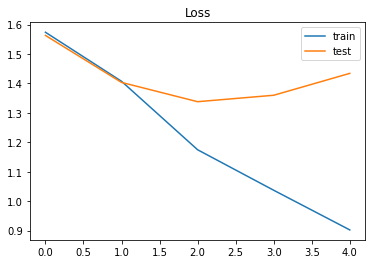

In [62]:
plt.title('Loss')
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

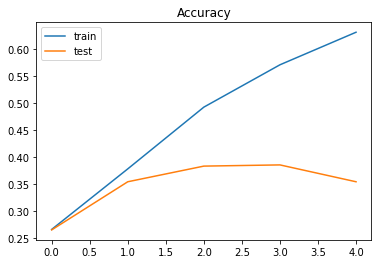

In [63]:
plt.title('Accuracy')
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()
plt.show()